This notebook contains some snippets I've been using to experiment.

# Initialization

In [6]:
import os
import itertools
import pickle
import numpy as np
import imageio
from tqdm import tqdm_notebook
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns

#from keras.models import load_model
#from keras.preprocessing import image
#from keras.preprocessing.image import ImageDataGenerator


%matplotlib inline

# Spirals
## Choose which experiment to look at

In [2]:
# Hyperparameters for spiraling
#seed_file = './experimental_results/ktran.jpg'
seed_file = './experimental_results/maynard_james_keenan.jpeg'
#seed_file = './experimental_results/gaius_baltar.png'
#seed_file = './experimental_results/jon_snow.jpeg'
#attribute = 'beautiful'
#attribute = 'broken'
#attribute = 'elegant'
attribute = 'pensive'


# Load some things with constant locations
seed_name = seed_file.split('/')[-1].split('.')[0]
results_folder = './experimental_results/%s_%s/' % (attribute, seed_name)
art_folder = './art_images/images/'
with open(results_folder + 'history.pkl', 'rb') as file_handle:
    max_val, history, style_images = pickle.load(file_handle)

# Get all of the folders that contain intermediate style transfer results
progress_folders = os.listdir(results_folder)
progress_folders.remove('history.pkl')
progress_folders.sort()

# Get the last style transfer image from each iteration
content_images = []
for progress_folder in progress_folders:
    intermediate_images = os.listdir(results_folder + progress_folder)
    styled_image = sorted(intermediate_images)[-1]
    content_images.append(results_folder + progress_folder + '/' + styled_image)

# Concatentate the full path into the list of style images
style_images = [art_folder + style_image for style_image in style_images]

## Create a function that makes spirals

In [3]:
def visualize_spiral(files, res=2**12, figsize=(20, 20)):
    spiral = Image.open(seed_file)
    fib = [1, 1]
    directions = itertools.cycle(['right', 'top', 'left', 'bottom'])

    for file_ in tqdm_notebook(files):
        # Figure out the direction the spiral is currently going
        direction = directions.next()

        # Some constants to help us figure out where to place everything
        reduction_ratio = float(fib[-2]) / fib[-1]
        reduced_res = int(res * reduction_ratio)

        # Figure out the bounding boxes for the old spiral and new image
        # according to which direction we're adding the image
        if direction == 'right':
            bbox_spiral = (0, 0)
            bbox_img = (reduced_res, 0)
            total_res = (res+reduced_res, res)
            old_spiral_size = (reduced_res, res)
        if direction == 'top':
            bbox_spiral = (0, res)
            bbox_img = (0, 0)
            total_res = (res, res+reduced_res)
            old_spiral_size = (res, reduced_res)
        if direction == 'left':
            bbox_spiral = (res, 0)
            bbox_img = (0, 0)
            total_res = (res+reduced_res, res)
            old_spiral_size = (reduced_res, res)
        if direction == 'bottom':
            bbox_spiral = (0, 0)
            bbox_img = (0, reduced_res)
            total_res = (res, res+reduced_res)
            old_spiral_size = (res, reduced_res)

        # Compress the older portion of the spiral
        spiral = spiral.resize(old_spiral_size)

        # Load the newest image in the spiral
        img = Image.open(file_)
        img = img.resize((res, res))

        # Put the old and new portions of the spiral together
        new_spiral = Image.new('RGB', total_res)
        new_spiral.paste(im=spiral, box=bbox_spiral)
        new_spiral.paste(im=img, box=bbox_img)
        spiral = new_spiral

        # Spiral out, keep going
        fib.append(fib[-1] + fib[-2])

    fig = plt.figure(figsize=figsize)
    ax = plt.imshow(spiral)

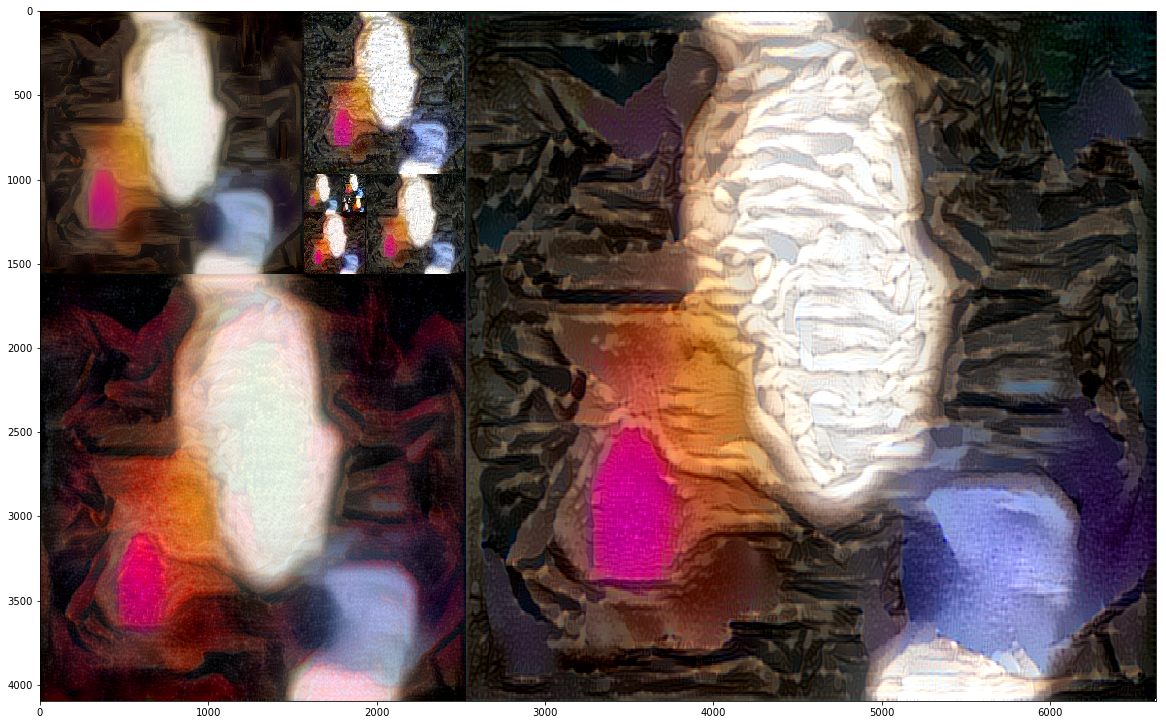

In [4]:
visualize_spiral(content_images)

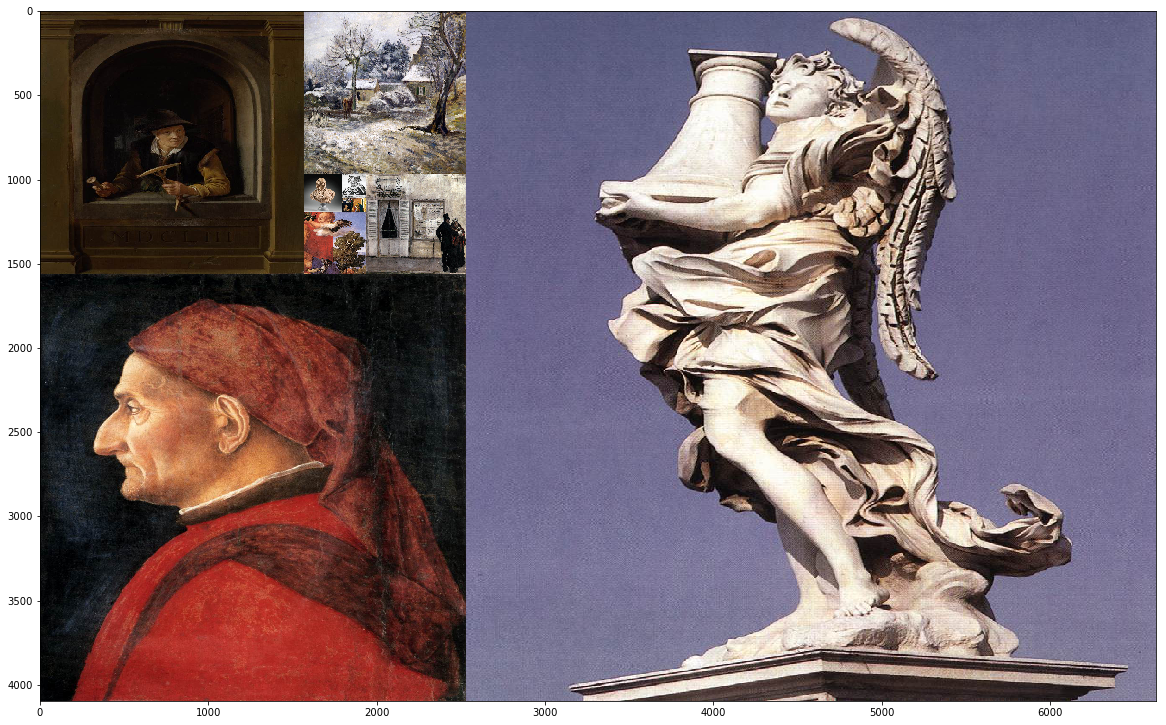

In [5]:
visualize_spiral(style_images)

# Make the videos

In [10]:
# Get ALL the style transfer images from each iteration
all_content_images = []
for progress_folder in progress_folders:
    intermediate_images = [results_folder + progress_folder + '/' + file_name
                           for file_name in os.listdir(results_folder + progress_folder)]
    all_content_images.extend(intermediate_images)

# Create the video
images = [imageio.imread(path) for path in all_content_images]
imageio.mimsave(results_folder + 'progression.gif', images, fps=20)

# Optimization Curves
## Attribute match for content images

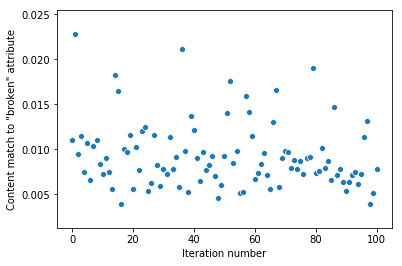

In [36]:
obj_vals = history.query_vals
ax = sns.scatterplot(range(len(obj_vals)), obj_vals)
_ = ax.set_xlabel('Iteration number')
_ = ax.set_ylabel('Content match to "%s" attribute' % attribute)

## Attribute match for style images

In [29]:
# Get the classfier
classifier = load_model('./sentiment_classification/resnet50_vso.h5')

# Initialize a dummy data generator so we can get our attribute labeling map
dummy_datagen = ImageDataGenerator()
dummy_gen = dummy_datagen.flow_from_directory('./sentiment_classification/train/',
                                              class_mode='categorical')
attr_map = dummy_gen.class_indices
attr_index = attr_map[attribute]


def predict_adj_match(img_path):
    # Pull the image
    img = image.load_img(img_path, target_size=(128, 128))

    # Standardize/preprocess the image
    array = image.img_to_array(img)
    array -= np.mean(array, axis=2, keepdims=True)
    array /= (np.std(array, axis=2, keepdims=True) + 1e-7)
    array_expanded = np.expand_dims(array, axis=0)

    # Feed the image to our trained ResNet model 
    probabilities = classifier.predict(array_expanded)[0, :]
    match = probabilities[attr_index]
    return match

Found 336072 images belonging to 260 classes.


In [ ]:
matches = [predict_adj_match(img_path) for img_path in style_images]
ax = sns.scatterplot(range(len(matches)), matches)
_ = ax.set_xlabel('Iteration number')
_ = ax.set_xlabel('Style match to "%s" attribute')

# Inspect all images

In [ ]:
figsize = (20, 20)

for content_file, style_file in zip(content_images, style_images):
    content_img = Image.open(content_file)
    style_img = Image.open(style_file)
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(content_img)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(style_img)